In [1]:
import yfinance as yf
import pandas   as pd
import numpy    as np
import matplotlib.pyplot as plt
from utils import *

In [74]:
spx = yf.Ticker("SPY").history(period="10y",interval = '1d')
spx  = pd.DataFrame(spx['Close'].dropna())

In [68]:
def bolbands(df, l=30, mul = 2):

    data = df.copy()
    data['sma'] = data.rolling(window=l).mean()
    std = data['Close'].rolling(window=l).std()
    
    data['upper'] = data['sma'] + std * mul
    data['lower'] = data['sma'] - std * mul
    
    return data

data = bolbands(df=spx)


In [69]:
def rsi_tradingview(ohlc: pd.DataFrame, period: int = 13, round_rsi: bool = True):
    """ 
    From : https://github.com/lukaszbinden/rsi_tradingview/blob/main/rsi.py
    
    """

    delta = ohlc.diff()

    up = delta.copy()
    up[up < 0] = 0
    up = pd.Series.ewm(up, alpha=1/period).mean()

    down = delta.copy()
    down[down > 0] = 0
    down *= -1
    down = pd.Series.ewm(down, alpha=1/period).mean()

    rsi = np.where(up == 0, 0, np.where(down == 0, 100, 100 - (100 / (1 + up / down))))

    return np.round(rsi, 2) if round_rsi else rsi

In [76]:
RSI = pd.DataFrame(rsi_tradingview(spx),index = spx.index)['2017-01-01':]
BB = bolbands(df=spx)['2017-01-01':]

In [77]:
# Trading Rule

signals = []

for i in range(len(RSI)):

    if (RSI.iloc[i] < 30).bool() and (BB['lower'].iloc[i] < BB['Close'].iloc[i]):
        
        signals.append(1)
        
    else:
        signals.append(0)

In [87]:
returns = backtester(signals,BB['Close'])
dd = max_dd(BB['Close'].pct_change().dropna().values.ravel())
wr = win_rate(pd.Series(signals), returns)

'Max Drawdown : '

-0.3

'Win Rate (TP / Total Trades) : '

0.0

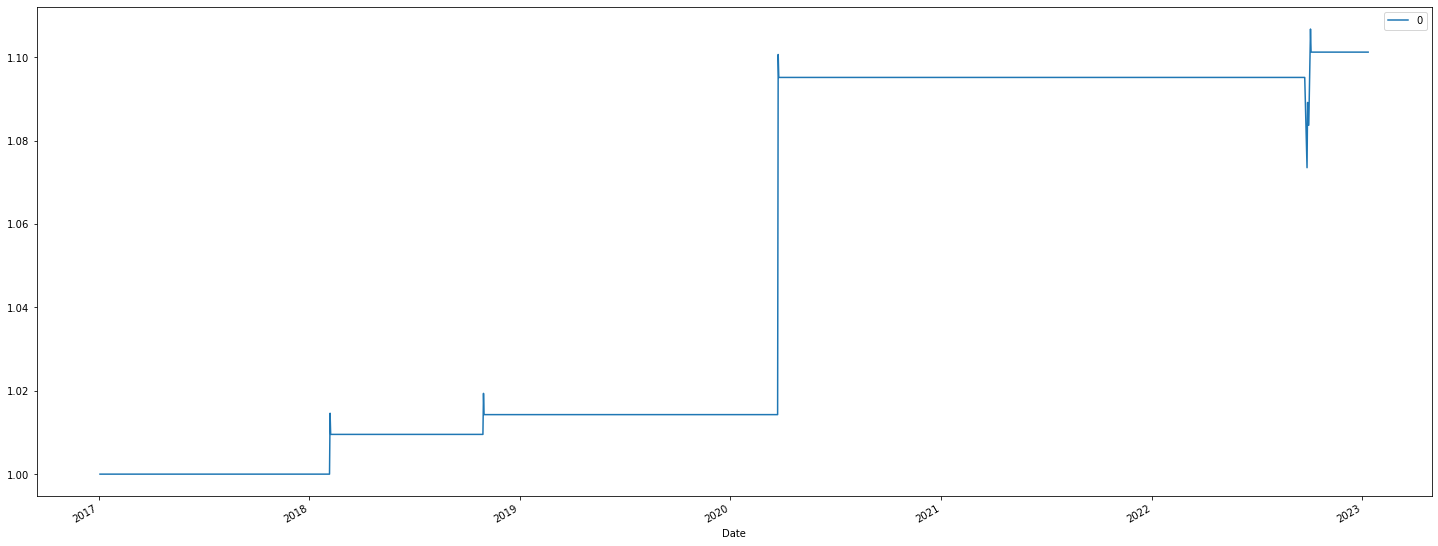

In [88]:
display('Max Drawdown : ',round(dd,1))
display('Win Rate (TP / Total Trades) : ', round(wr,3))
returns.plot(figsize = (25,10))
plt.show()